In [1]:
# from models import FCC, Siamese, Siamese_no_sharing
from models_v2 import FCC, Siamese
import dlc_practical_prologue
import torch
from torch import nn
from torch import optim
import torchvision
from torch.nn import functional as F
from tqdm import trange
import matplotlib.pyplot as plt
import models
# from utils import Proj1
import utils

In [6]:
# Load data
train_input, train_target, train_classes, test_input, test_target, test_classes = dlc_practical_prologue.generate_pair_sets(1000)

train_data = (train_input, train_target, train_classes)
test_data = (test_input, test_target, test_classes)

# INstantiate models
models = (FCC(), FCC(share=True), FCC(aux=True), FCC(share=True, aux=True), Siamese(), Siamese(share=True), Siamese(aux=True), Siamese(share=True, aux=True))

model_names = ('FCC' , 'FCC with shared weights', 'FCC with auxiliary loss', 'FCC with auxiliary loss and shared weights',
               'Siamese without wwight sharing', 'Siamese with shared weights', 'Siamese with auxiliary loss', 'Siamese with auxiliary loss and shared weights')

# models = (FCC(), FCC(), Siamese_no_sharing(), Siamese_no_sharing(), Siamese(), Siamese())
# models[1].setAuxillary()
# models[3].setAuxillary()
# models[5].setAuxillary()
# model_names = ('FCC' , 'FCC w Auxiliary Loss','Siamese (no weight sharing)', 'Siamese (no weight sharing and Auxiliary loss)', 'Siamese (weight sharing)', 'Siamese (weight sharing and Auxiliary Loss)')

In [7]:
def evaluate_all(models, model_names, train_data, test_data, batch_size=100, rounds=10, epochs=25):
    '''
    - train and test_date should be complete (train_input, train_target, train_classes)
    - model_names are strings, that should contain the word Auxiliary
    '''
    # Unpack data
    train_input, train_target, train_classes = train_data
    test_input, test_target, test_classes = test_data
    # Initialize err rates arrays
    train_error_rates = torch.empty(rounds)
    test_error_rates = torch.empty(rounds)
    
    # Iterate models
    for model, name in zip(models, model_names):
        print(f'Training model {name}:')
        # Iterate over r to get average
        for r in trange(rounds):
            # Call train_model with the correct parameters
            if 'Aux' in name:
                utils.train_model(model, train_input, train_target, batch_size, epochs, train_classes)
            else:
                utils.train_model(model, train_input, train_target, batch_size, epochs, train_classes=None)
            # Get error on train and test set
            train_error_rates[r] = utils.compute_nb_errors(model, train_input, train_target, batch_size)/train_input.size(0)
            test_error_rates[r] = utils.compute_nb_errors(model, test_input, test_target, batch_size)/test_input.size(0)
            
        #print(f'For the model {name}, the train average error rate is {train_error_rates.mean()} and the test average error rate {test_error_rates.mean()}\n')
        print('For the model {}, the train average error rate is {:.3}% and the test average error rate is {:.3}%.\n'
              .format(name, 100*train_error_rates.mean(), 100*test_error_rates.mean()))
#     return error_rates

In [8]:
evaluate_all(models, model_names, train_data, test_data, batch_size=100, rounds=10, epochs=25)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Training model FCC:


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For the model FCC, the train average error rate is 0.5% and the test average error rate is 19.1%.

Training model FCC with shared weights:


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For the model FCC with shared weights, the train average error rate is 0.5% and the test average error rate is 16.4%.

Training model FCC with auxiliary loss:


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For the model FCC with auxiliary loss, the train average error rate is 0.7% and the test average error rate is 17.3%.

Training model FCC with auxiliary loss and shared weights:


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For the model FCC with auxiliary loss and shared weights, the train average error rate is 0.9% and the test average error rate is 17.8%.

Training model Siamese without wwight sharing:


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For the model Siamese without wwight sharing, the train average error rate is 10.7% and the test average error rate is 22.3%.

Training model Siamese with shared weights:


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For the model Siamese with shared weights, the train average error rate is 7.1% and the test average error rate is 14.9%.

Training model Siamese with auxiliary loss:


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

For the model Siamese with auxiliary loss, the train average error rate is 7.6% and the test average error rate is 19.4%.

Training model Siamese with auxiliary loss and shared weights:


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.23s/it]

For the model Siamese with auxiliary loss and shared weights, the train average error rate is 7.2% and the test average error rate is 15.0%.



In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
for model in models:
    print(count_parameters(model))

483618
483618
483618
483618
135480
135480
135480
135480


In [7]:
def plot(train_loss, test_loss, train_acc, test_acc):
    plt.figure(figsize = (9, 6))
    
    ax_loss = plt.gca()
    ax_loss.set_xlabel('Epochs')
    ax_loss.set_ylabel('Loss')
    p1 = ax_loss.plot(train_loss, 'r', label = 'Train Loss')
    p2 = ax_loss.plot(test_loss,  'b', label = 'Test Loss')
    
    ax_acc = ax_loss.twinx()  # instantiate a second axes that shares the same x-axis

    ax_acc.set_ylabel('Accuracy')  # we already handled the x-label with ax1
    p3 = ax_acc.plot(test_acc, 'g', label = 'Test Accuracy')
    p4 = ax_acc.plot(train_acc, 'k', label = 'Train Accuracy')
    legends = [l.get_label() for l in p1+p2+p3+p4]
    plt.grid()
    ax_acc.legend(p1+p2+p3+p4, legends)
    plt.show()


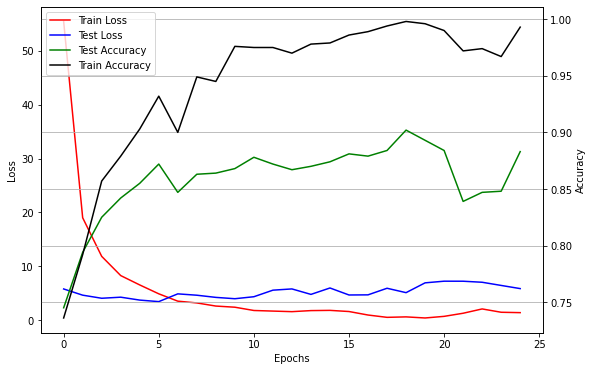

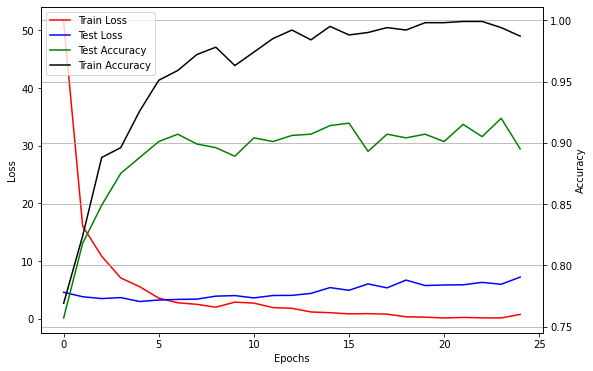

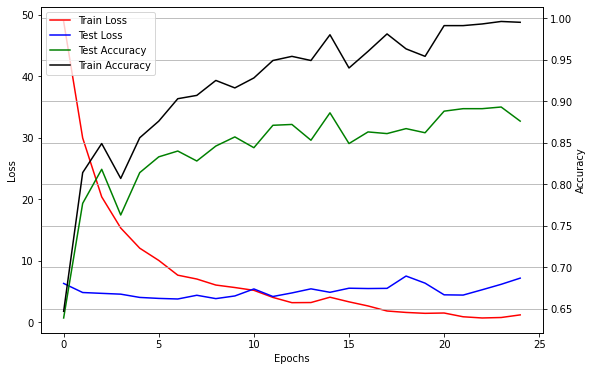

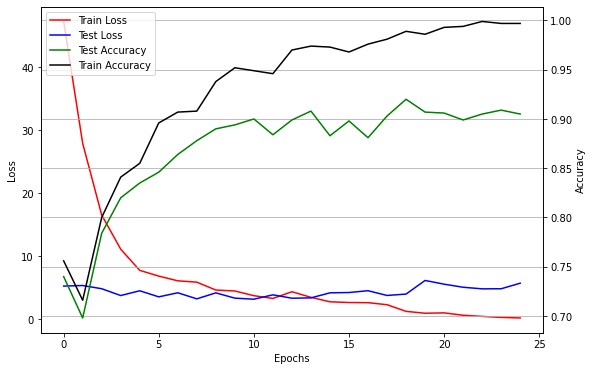

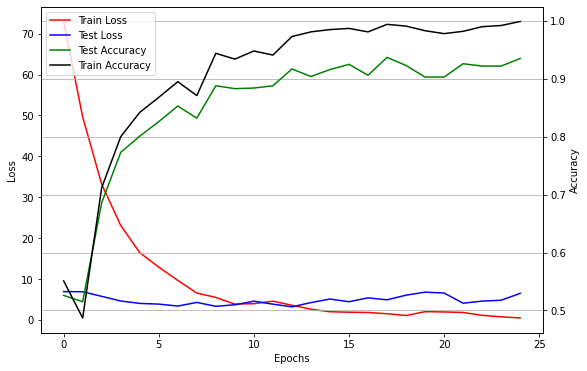

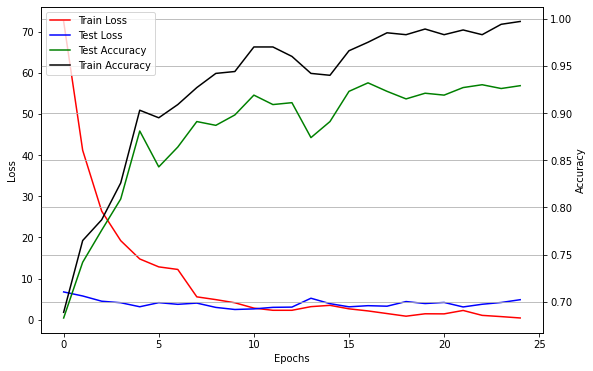

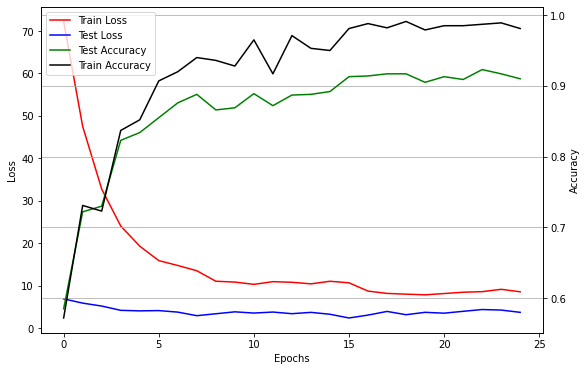

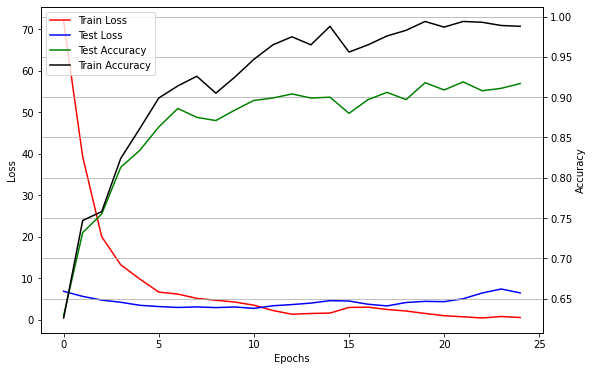

In [8]:
models = (FCC(), FCC(share=True), FCC(aux=True), FCC(share=True, aux=True), Siamese(), Siamese(share=True), Siamese(aux=True), Siamese(share=True, aux=True))

model_names = ('FCC' , 'FCC with shared weights', 'FCC with auxiliary loss', 'FCC with auxiliary loss and shared weights',
               'Siamese without wwight sharing', 'Siamese with shared weights', 'Siamese with auxiliary loss', 'Siamese with auxiliary loss and shared weights')


for model in models:
    losses = utils.train_model_track_errors(model, train_input, train_target, 100, 25, test_input, test_target, train_classes)
    utils.plot(*losses)